In [ ]:
!pip install hyppo

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for hyppo: filename=hyppo-0.2.1-cp37-none-any.whl size=98836 sha256=ffe896de9a604d036ba20d391142d340430e32e4f8a7e7821f628e7e30c58429
  Stored in directory: /root/.cache/pip/wheels/ea/ea/b1/df7c33975256fd60ab8abfc467fcc0247e66a2a7cff3e2d933
Successfully built hyppo


In [43]:
#imports
from scipy.stats import multiscale_graphcorr as MGC
import scipy
import numpy as np
import torch
import matplotlib.pyplot as plt
from inspect import getmembers
import inspect
import warnings
import hyppo
import sys
from pathlib import Path
import pickle
import glob


https://stackoverflow.com/questions/43729052/generator-function-yield-much-faster-then-iterator-class-next
Explains what type of function/generator to use for performance

In [69]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size  

In [ ]:

class function_generator():
    def __init__(self, sample_size=100):

        self.operations = ["arccos","arccosh","arcsin","arcsinh","arctan","arctan2",
                          "arctanh","heaviside","log","log10","log1p","log2",
                          "multiply","sin","sinh","sqrt","square","tan",
                          "tanh","divide", 'add', 'subtract']

        # one term operations
        self.one_term_operations = ["arccos","arccosh","arcsin","arcsinh","arctan",
                                    "arctanh","log","log10","log1p","log2","sin",
                                    "sinh","sqrt","square","tan","tanh"]

        self.hyppo_functions= ["linear","exponential","cubic", "joint_normal",
                    "step","quadratic", "w_shaped", "spiral",
                    "logarithmic", "fourth_root", "sin_four_pi", "sin_sixteen_pi",
                    "square", "two_parabolas", "circle", "ellipse", "diamond",
                    "multiplicative_noise", "multimodal_independence"]

        # two term operations
        self.two_term_operations = ["arctan2", "heaviside", "multiply",
                                    "divide"]

        

        # TODO adding and subtracting new terms
        self.add_term_operations = ["add", "subtract"]

        # check if all operations are contained in the other sets
        assert (set(self.one_term_operations).union(set(self.two_term_operations)).
                union(set(self.add_term_operations)) == set(self.operations))
        
        self.sample_size = sample_size

        self.operation_scale_dict = {"arccos":  (-0.99,0.99),
                                      "arccosh": (1.01,10),
                                      "arcsin":  (-0.99,0.99),
                                      "arcsinh": (-np.pi,np.pi),
                                      "arctan":  (-3,3),
                                      "arctan2": ((-0.99,0.99),(-0.99,0.99)),
                                      "arctanh": (-0.99,0.99),
                                      "heaviside": ((-0.99,0.99),(-0.99,0.99)),
                                      "log": (0.01, 3),
                                      "log10": (0.01, 3),
                                      "log1p": (0.01, 3),
                                      "log2": (0.01, 3),
                                      "multiply": ((-1,1), (-1,1)),
                                      "sin": (-np.pi,np.pi),
                                      "sinh": (-3,3),
                                      "sqrt": (0,1),
                                      "square": (-1,1),
                                      "tan": (-np.pi/2+0.01, np.pi/2-0.01),
                                      "tanh":(-np.pi, np.pi),
                                      "divide": ((-2,2),(0.01,2)),
                                      "subtract": (-1,1),
                                      "add": (-1,1)}

        self.samples_dict = {}


    def yield_sample(self):
        """calls the other methods to yield samples lazily"""
        while True:
            
            # initialize the y_prev and x
            init_operator = np.random.choice(self.hyppo_functions)
            if init_operator in ['multiplicative_noise','multimodal_independence']:
                x, y_init = getattr(hyppo.tools, init_operator)(self.sample_size, 1)
            else:
                noise = np.random.choice([True, False], p=[0.3, 0.7])
                x, y_init = getattr(hyppo.tools, init_operator)(self.sample_size, 1,
                                                                noise=bool(noise))
                
            
            y_prev=y_init
            # store the operations for targets
            order_of_operations=[init_operator]

            

            #initialize a list for the terms
            terms = []

            # this controls how many successive operations are likely to happen
            rand=np.random.random()
            operation_count = 0
            while rand > 0.6 or len(order_of_operations)<2:
                # see if we add a new operation after this one
                rand = np.random.random()
                # get a random operator from the possible operators
                # and append it to a list that can be used as category targets
                # later
                operator = np.random.choice(self.operations)
                # increase the likelihood of creating a new term if there are already
                # a lot of operations, reset to zero if a new term has just been created
                if operation_count*(rand**2) > rand or operation_count>2:
                    operator = np.random.choice(self.add_term_operations)



                operation_count +=1

                # get the actual function with this operator
                funct = getattr(np, operator)

                # TODO scale y_prev based on range that creates a representative shape 
                # of the selected function
                scale = self.operation_scale_dict[operator]
                if operator in self.one_term_operations:
                    order_of_operations.append(operator)
                    low = scale[0]
                    high = scale[1]
                    
                    # scale to 0-1
                    y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())
                    # scale to new scale
                    y_prev = y_prev*(high-low) + low
                    
                    #update the result and y_prev for the next operation
                    y = funct(y_prev)
                    y_prev = y

                elif operator in self.two_term_operations:
                    order_of_operations.append(operator)

                    # y_prev
                    low_y, high_y= scale[0]
                    # scale to 0-1
                    y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())
                    # scale to new scale
                    y_prev = y_prev*(high_y-low_y) + low_y

                    # y_temp
                    low_x, high_x= scale[1]
                    # scale to 0-1
                    x_temp = (x - x.min()) /(x.max() - x.min())
                    # scale to new scale
                    x_temp = x_temp*(high_x-low_x) + low_x

                    #update the result and y_prev for the next operation
                    y = funct(y_prev, x_temp)
                    y_prev = y

                elif operator in self.add_term_operations and operation_count>1:
                    # append operation
                    order_of_operations.append(operator)
                    terms.append(y_prev)

                    # reset y_prev for a new term
                    y_prev = y_init
                    order_of_operations.append(init_operator)
                    operation_count=0
                    # still have to actually perform the operation. Addition and subtraction happen later

                elif operator in self.add_term_operations and operation_count<=1:
                    rand=1
          
            y=y_prev
            #append the last term
            terms.append(y)
            if len(terms)>1:
                # get the order of operation
                term_operators = [operator for operator in order_of_operations if (operator in self.add_term_operations)]

                self.terms = terms

                # scale all terms
                for i, term in enumerate(terms):
                    term = np.array(term)
                    term = ((term - term.min())/(term.max()-term.min()))*np.random.random()
                    terms[i] = term

                y_temp = terms[0]
                for i, operator in enumerate(term_operators):
                    # get the function with this operator
                    funct = getattr(np, operator)
                    term_after = terms[i+1]
                    y_temp = funct(y_temp, term_after)

                # plt.plot(x, np.array(terms).T)

                y=y_temp
          # plt.plot(x, y, 'ro', markersize=2)
          # plt.pause(0.001)
          

            yield (x, y), order_of_operations


  

    def generate_MGC_maps(self, n_samples):

        # instantiate the generator
        gen = self.yield_sample()


        labels = []
        # generate the data
        for i in range(n_samples):
            print(f"\r{i} {len(self.samples_dict)}", end="")
            (x, y), label = next(gen)
            labels.append(label)
            try:
                if not any(np.isnan(y)):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        _,_,MGC_DICT = MGC(x,y, reps=0, workers=-1)
#                     fig, axs = plt.subplots(1,2)
#                     axs[0].imshow(MGC_DICT["mgc_map"])
#                     axs[0].set_title(label)
#                     axs[0].invert_yaxis()
#                     axs[1].twinx()
#                     axs[1].plot(x, y, 'ro', markersize=2)
#                     plt.pause(0.001)
                    
                    self.samples_dict[i] = (MGC_DICT['mgc_map'], (x,y), label)
                    dict_size = get_size(self.samples_dict)
                    if dict_size>10e6:
                        print(dict_size)
                        path=Path("data")
                        num=len(list(path.glob("*")))
                        
                        with open(Path(path, str(num)+".pkl"), 'wb') as fp:
                             pickle.dump(self.samples_dict, fp)
                                  
                        self.samples_dict={}
                        

            except IndexError:
                pass




class_instance = function_generator(128)
generator = class_instance.yield_sample()
class_instance.generate_MGC_maps(100000)

#should be around 12 gb of data

36 35

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


63 62

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


79 7710056498
159 7910072312
243 8310084153
325 8110084099
407 8110083108
485 7710061370
565 7910070477
652 8610110173
736 8310090570
813 7610059203
894 8010074877
982 8710110089
1065 8210083413
1144 7710067284
1158 12

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


1229 8210089028
1308 7810071351
1392 8210088619
1470 7710058665
1521 48

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


1555 8210089203
1637 8010081746
1715 7710067073
1796 8010066228
1876 7910069680
1953 7610053326
2038 8410092394
2117 7810059431
2205 8710113219
2287 8110086526
2369 8110079420
2452 8110079911
2531 7810065477
2609 7710059789
2690 8010070511
2770 7910067315
2849 7810069991
2932 8210083265
3016 8310088963
3091 73

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


3095 7710045451
3177 8110081137
3194 15

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


3260 8110086224
3337 7610048692
3414 7610052682
3495 8010063598
3581 8510104799
3659 7710060660
3738 7810069547
3815 7610047658
3901 8510099846
3978 7610061675
4063 8310089522
4142 7810055944
4221 7810060499
4298 7610056058
4386 8710114811
4455 67

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


4474 8610104516
4556 8110080797
4570 12

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


4637 7910067002
4720 8210089822
4803 8210081682
4885 8110085368
4966 8010070019
5046 7910073066
5128 8110070882
5209 8010078297
5292 8210082462
5373 7910064394
5453 7810062436
5535 8110078089
5618 8210084464
5697 7810069046
5785 8710103127
5868 8210087564
5953 8410090709
6033 7910066966
6116 8210080118
6200 8310096118
6285 8410096676
6371 8410096096
6422 49

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


6459 8610112523
6542 8210084112
6626 8310087711
6707 8010078944
6789 8110075607
6868 7810063612
6948 7910070385
7028 7910074498
7111 8210087823
7187 7510049323
7268 8010077019
7328 58

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


7347 7710062467
7364 15

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


7435 8610106305
7516 8010074998
7597 7910067527
7680 8210080444
7766 8510100994
7850 8310090167
7931 8010079703
8008 7610055924
8020 10

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


8089 7910066369
8173 8310099584
8253 7810071453
8333 7910070380
8417 8310090740
8504 8510104016
8586 8110076994
8670 8210075451
8754 8310094196
8835 8010073271
8917 8110079241
8999 8010072988
9045 45

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


9083 8210078391
9162 7810066830
9245 8210080474
9328 8210081655
9406 7710062749
9484 7710064804
9565 7910068048
9645 7910066988
9726 8010062234
9807 8010073583
9825 16

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


9889 8010070371
9970 8010074337
10048 7610053196
10113 63

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


10134 8410084515
10216 8110077809
10294 7710061490
10351 55

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


10377 8110084101
10458 8010076947
10542 8210080296
10622 7910070335
10703 8010075633
10782 7810074218
10862 7910072788
10941 7810068492
11019 7710064137
11103 8310090502
11183 7910071321
11267 8310092316
11350 8210080150
11399 47

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


11434 8210080628
11517 8210082771
11563 45

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


11601 8210075703
11651 48

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


11679 7610058924
11760 8010071771
11842 8010074080
11878 34

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


11923 7910072962
11933 8

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


11947 21

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


12007 8110084555
12017 9

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


12093 8410099492
12179 8510106589
12262 8210088131
12342 7910072685
12423 8010075373
12502 7810062820
12581 7810070761
12660 7610054684
12743 8210076296
12823 7910062649
12904 8010080745
12987 8210083107
13071 8310087332
13144 71

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


13157 8410092251
13233 7510052031
13313 7810067407
13392 7810066381
13472 7910069449
13554 8110073513
13591 35

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


13636 8010080898
13718 8110080461
13800 8110081028
13881 8010066269
13966 8310082785
14051 8410101887
14131 7910072825
14212 8010072048
14290 7710054507
14371 8010078496
14450 7810061362
14532 8110074312
14570 36

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


14619 8510096713
14700 7910070790
14783 8210087060
14863 7910073466
14944 8010079524
15025 8010077786
15105 7910057656
15189 8310093563
15272 8210085944
15317 43

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())
<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


15355 8010073154
15390 33

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


15441 8410090621
15521 7910069815
15601 7910073564
15680 7810065782
15763 8210085632
15843 7910072164
15926 8210079371
16006 7910067163
16093 8610102689
16176 8210083312
16223 45

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


16260 8210083750
16347 8610099376
16431 8310091250
16511 7910068637
16593 8110081772
16675 8110075367
16761 8510100683
16847 8410098716
16928 8010074555
17007 7810066356
17086 7810064688
17165 7810067196
17247 8010076300
17335 8710115985
17413 7610059393
17493 7910072066
17574 8010078353
17658 8310084174
17745 8610100102
17774 27

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


17806 58

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


17834 8610106130
17917 8210089430
17995 7610053619
18072 7610057520
18156 8210079983
18241 8410095789
18322 8010070724
18402 7910073119
18487 8410091020
18569 8110075687
18655 8510101357
18705 48

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


18741 8310095494
18824 8210084984
18902 7710061634
18983 8010068150
19073 8910120197
19158 8310088901
19240 8110084857
19322 8010074069
19401 7810069806
19483 8110084293
19565 8110078854
19648 8110080787
19729 7910072312
19814 8410097376
19856 40

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


19893 7710062793
19978 8410098535
20064 8510095549
20073 8

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


20145 7910068792
20225 7910070764
20309 8310094976
20389 7910066470
20417 26

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


20446 54

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


20474 80

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


10070006
20554 7910071134
20637 8210085804
20717 7910067223
20797 7910075161
20877 7910075425
20961 8210088869
21048 8610098885
21128 7910070125
21209 7910069259
21294 8410094772
21374 7910060218
21457 8210092059
21542 8410096346
21626 8310091283
21707 8010059704
21786 7810064882
21856 68

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


21864 7610054976
21948 8210084106
22028 7910073938
22106 7710061028
22187 8010071974
22266 7810056884
22345 7810069775
22424 7810061200
22504 7810067934
22588 8310092237
22669 8010070917
22748 77

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


22751 8010073521
22834 8210087522
22914 7910069408
22995 7910069951
23078 8210083470
23157 7810062435
23241 8310092991
23325 8310089546
23332 6

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


23409 8210088450
23488 7810060589
23566 7710064384
23646 7910071800
23727 8010072622
23813 8510103654
23892 7710057344
23972 7910069741
24032 58

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


24054 8010082762
24131 7610058212
24214 8210085972
24295 8010066802
24382 8610102537
24461 7810061111
24540 7810064061
24623 8110077693
24701 7710052065
24785 8210082010
24866 8010078220
24947 8010074457
25036 8710114484
25120 8310090332
25202 8010075388
25282 7910062197
25363 8010073262
25448 8410093897
25533 8410085250
25611 7710062796
25693 8010073059
25767 72

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


25777 8210087165
25859 8110080251
25945 8510104593
25952 5

<ipython-input-74-ee257688a383>:129: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


26027 8010081746
26111 8310082449
26192 8010075317
26272 7910073392
26354 8110079095
26442 8710112946
26528 8410098991
26606 7710059122
26686 7910068036
26764 7710048711
26847 8210084916
26934 8610103864
27018 8210081193
27105 8610107736
27195 8810114324
27274 7810069620
27287 12

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


27358 8210083501
27441 8110085168
27493 50

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


27525 8210087325
27604 7810067531
27685 8010074680
27767 8110074952
27850 8210090634
27930 7910071169
28014 8310089213
28096 8010077575
28173 7610052652
28257 81

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


28259 8310090779
28341 8110080015
28351 8

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


28424 8110085266
28497 70

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


28508 8110085060
28590 8110086427
28675 8410100127
28760 8410097894
28842 8110084923
28921 7710055752
29010 8810111787
29035 23

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


29089 7710050094
29167 7710060468
29246 7810062342
29330 8310092644
29411 8010078338
29493 8010077192
29572 7810061611
29654 8110077255
29739 8410081270
29818 7810061737
29901 8210087164
29984 8210090117
30066 8110081604
30148 8110081416
30228 7810063716
30312 8310091089
30397 8410090749
30478 8010074907
30562 8310091275
30579 15

<ipython-input-74-ee257688a383>:115: RuntimeWarning: invalid value encountered in true_divide
  y_prev = (y_prev - y_prev.min()) /(y_prev.max() - y_prev.min())


30642 7810064838
30725 8210075128
30801 74

<ipython-input-74-ee257688a383>:170: RuntimeWarning: invalid value encountered in true_divide
  term = ((term - term.min())/(term.max()-term.min()))*np.random.random()


30804 77

In [ ]:

class function_generator():
  def __init__(self, sample_size=100):



    self.hyppo_functions= ["linear","exponential","cubic", "joint_normal",
                "step","quadratic", "w_shaped", "spiral", "uncorrelated_bernoulli",
                "logarithmic", "fourth_root", "sin_four_pi", "sin_sixteen_pi",
                "square", "two_parabolas", "circle", "ellipse", "diamond",
                "multiplicative_noise", "multimodal_independence"]
    
    
    self.SIZE = sample_size


  def yield_sample(self):
    """calls the other methods to yield samples lazily"""
    while True:
      # get scaling factors randomly selected from an exponential distribution
      a = np.random.exponential()#scale = np.abs(np.random.random()))
      b = np.random.exponential()#scale = np.abs(np.random.random()))

      operator = np.random.choice(self.hyppo_functions)
      print(operator)

      funct = getattr(hyppo.tools, operator)

      if operator in ['multiplicative','multimodal_independence']:
        noise = False
      else:
        noise = False

      if operator in ["linear","exponential","cubic", "step","quadratic", 
                      "w_shaped", "spiral", "fourth_root", "sin_four_pi", 
                      "sin_sixteen_pi","square", "circle", 
                      "ellipse", "diamond"]:
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b))
      
      elif operator =="two_parabolas":
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), 
                     prob=np.random.random())
        
      elif operator == 'uncorrelated_bernoulli':
        x, y = funct(self.SIZE,1, noise=noise, prob=np.random.random())

      elif operator in ["joint_normal", "logarithmic"]:
        x, y = funct(self.SIZE,1, noise=noise)
      
      elif operator == 'multimodal_independence':
        x, y = funct(self.SIZE,1, prob=np.random.random(), sep1=a, sep2=b)

      elif operator == 'multiplicative':
        x, y = funct(self.SIZE,1)

      yield (x, y), operator

  def generate_MGC_maps(self, n_samples):

    # instantiate the generator
    gen = self.yield_sample()


    labels = []
    # generate the data
    for i in range(n_samples):
      print(i)
      (x, y), label = next(gen)
      
      labels.append(label)
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _,_,MGC_DICT = MGC(x,y, reps=0)
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(MGC_DICT["mgc_map"])
        axs[0].set_title(label)
        axs[0].invert_yaxis()
        axs[1].twinx()
        axs[1].plot(x, y, 'ro', markersize=2)
        plt.pause(0.001)




class_instance = function_generator(100)
generator = class_instance.yield_sample()
class_instance.generate_MGC_maps(100)

    # plt.title(order_of_operations)
    # stat, p_value, mgc_dict = MGC(x, y, reps=0)
    # plt.twinx().imshow(mgc_dict['mgc_map'], cmap='Purples')
    # plt.gca().invert_yaxis()
    # plt.plot(x,y, 'ro', markersize=2)
    # plt.pause(0.000000001)



0.4867827172013097
square
0.7871696835466937
square
0.5940196566066747
add
terms 1
0.6482973883105771
tanh
0.28446583917160795
log10
len terms 2
['add']


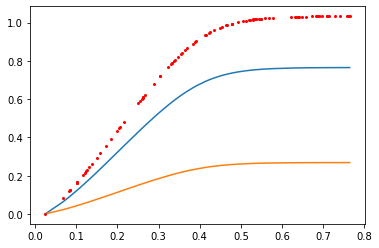

Text(0.5, 1.0, "['square', 'square', 'add', 'tanh', 'log10']")

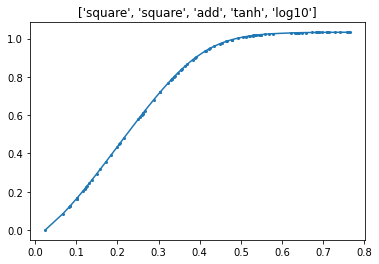

In [ ]:
(x_test, y_test), order = next(generator)
plt.plot(x_test, y_test, 'o-', markersize=2)
plt.title(order)